<a href="https://colab.research.google.com/github/rk2026/data/blob/main/cutfill_prototyping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 77.0 MB/s eta 0:00:00


In [2]:
!pip install mapclassify

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 3.3 MB/s eta 0:00:00


In [3]:
# prompt: upload shape file from my local computer and convert to to geodataframe and EPSG= 32645

import geopandas as gpd
from google.colab import files
import io
import mapclassify

uploaded = files.upload()

# Initialize gdf outside the loop to store the final GeoDataFrame
gdf = None  # Or gpd.GeoDataFrame() if you prefer an empty GeoDataFrame

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

  # Assuming the uploaded file is a shapefile (.shp)
  try:
    gdf = gpd.read_file(io.BytesIO(uploaded[fn])) # Assign to the outer gdf
    # Reproject to EPSG:32645
    gdf = gdf.to_crs(epsg=32645)
    print(gdf.crs)
    print(gdf.head())
  except Exception as e:
    print(f"Error processing file: {e}")
# Now gdf will be accessible outside the loop

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 72.6 MB/s eta 0:00:00


In [5]:
# prompt: "/content/RASUWA_Gosaikunda.tif" is my dem and I want to project to epsg:32645.

import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

# Open the input raster
with rasterio.open("/content/RASUWA_Gosaikunda.tif") as src:
    # Define the target CRS
    dst_crs = 'EPSG:32645'

    # Calculate the transformation parameters
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds
    )

    # Define the output raster profile
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    # Create the output raster
    with rasterio.open('/content/RASUWA_Gosaikunda_projected.tif', 'w', **kwargs) as dst:
        # Reproject the raster data
        reproject(
            source=rasterio.band(src, 1),
            destination=rasterio.band(dst, 1),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=Resampling.nearest
        )

In [38]:
import geopandas as gpd
from google.colab import files
import io
import mapclassify

uploaded = files.upload()

# Initialize gdf outside the loop to store the final GeoDataFrame
gdf = None  # Or gpd.GeoDataFrame() if you prefer an empty GeoDataFrame

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

  # Assuming the uploaded file is a shapefile (.shp)
  try:
    gdf = gpd.read_file(io.BytesIO(uploaded[fn])) # Assign to the outer gdf
    # Reproject to EPSG:32645
    gdf = gdf.to_crs(epsg=32645)
    print(gdf.crs)
    print(gdf.head())
  except Exception as e:
    print(f"Error processing file: {e}")
    print(e) # This will print the actual error for debugging

# Now gdf will be accessible outside the loop

Saving road_xyz1.zip to road_xyz1 (2).zip
User uploaded file "road_xyz1 (2).zip" with length 37939 bytes
EPSG:32645
      z  rowid  elevation  LATITUDE  LONGITUDE  \
0  2091      1       2000    28.109     85.298   
1  2091      1       2000    28.109     85.298   
2  2091      2       2000    28.109     85.298   
3  2091      2       2000    28.109     85.298   
4  2091      3       2000    28.109     85.298   

                                    geometry  
0  POINT Z (332826.397 3110435.918 2090.875)  
1  POINT Z (332826.397 3110435.918 2090.875)  
2  POINT Z (332826.397 3110435.918 2090.875)  
3  POINT Z (332826.151 3110435.933 2090.875)  
4  POINT Z (332826.151 3110435.933 2090.875)  


In [ ]:
/content/RASUWA_Gosaikunda_projected.tif

In [70]:
# prompt: I have 'gdf' point data and want to create raster data from this. The raster value will be derived from 'elevation' column.  the pixel size will be  20.575391857775447

import rasterio
from rasterio.features import rasterize
import numpy as np

# Assuming 'gdf' is your GeoDataFrame and 'elevation' is the column with elevation values
# and pixel_size is defined

pixel_size = 20.575391857775447

# Define the output raster's extent based on the GeoDataFrame's bounds
minx, miny, maxx, maxy = gdf.total_bounds
width = int(np.ceil((maxx - minx) / pixel_size))
height = int(np.ceil((maxy - miny) / pixel_size))
transform = rasterio.transform.from_bounds(minx, miny, maxx, maxy, width, height)

# Create an empty raster with the defined parameters
raster_data = np.zeros((height, width), dtype=np.float32)  # Or use another suitable data type

# Rasterize the point data using the 'elevation' column as values
shapes = ((geom, value) for geom, value in zip(gdf.geometry, gdf.elevation))
burned = rasterize(shapes=shapes, fill=np.nan, out=raster_data, transform=transform, all_touched=True, dtype=np.float32)

# Define metadata for the output raster
meta = {
    'driver': 'GTiff',
    'height': height,
    'width': width,
    'count': 1,  # Number of bands
    'dtype': rasterio.float32,  # Data type of the raster
    'crs': gdf.crs,
    'transform': transform,
    'nodata': np.nan
}

# Save the raster to a file
with rasterio.open('output_raster.tif', 'w', **meta) as dst:
    dst.write(burned, 1)

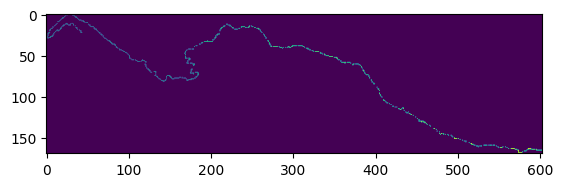

In [76]:
import matplotlib.pyplot as plt
import rasterio

# Open the raster file
with rasterio.open('output_raster.tif') as src:
    # Read the raster data
    raster_data = src.read(1)

    # Display the raster image using matplotlib
    plt.imshow(raster_data, cmap='viridis') # You can change the colormap if needed
    # plt.colorbar()
    # plt.title('Output Raster')
    # plt.show()

<PIL.Image.Image image mode=F size=603x169>